In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv
import pandas as pd
import random
from random import choice
from random import sample
from itertools import combinations

import metis # lulz

# TODO:
# I. Modify calculate closeness, betweeness to have check_neigbors option as parameter  DONE 
# II. Add sections that calculates etimation with check_neighbors = False DONE
# III. Do the centralities for the partitioned graph  - Degree, Closeness, Betweeness, Border DONE - EXCEPT BORDER
# IV. Hybrid implementation of selection landmaks strategy
# V. Unify with same random seed

# Data load

In [2]:
# grap init
G_dblp = nx.Graph()


# dblp.tsv
with open('data/dblp/com-dblp/out.com-dblp.tsv', 'r') as file:
    for line in file:
        source, target = line.strip().split(' ')
        G_dblp.add_edge(int(source), int(target))

num_edges = G_dblp.number_of_edges()
num_nodes = G_dblp.number_of_nodes()


print("number of directed edges in dblp.tsv:", num_edges)
print("number of directed nodes in dblp.tsv:", num_nodes)

number of directed edges in dblp.tsv: 1049866
number of directed nodes in dblp.tsv: 317080


## Choosing random nodes for landmark

In [3]:
def generate_rng_landmark_list(graph, num_landmarks=20):
    """
    Generate a list of random landmarks from the given graph.

    Parameters:
    - graph: NetworkX graph
    - num_landmarks: Number of landmarks to generate (default is 20)
    Returns:
    - landmark_list: List of random landmarks
    """
    landmark_list = []

    for i in range(num_landmarks):
        random_node = choice(list(graph.nodes()))
        if random_node not in landmark_list:
            landmark_list.append(random_node)

    return landmark_list


## Calculating each node's degree

In [4]:
def calculate_degree_centrality(graph, N=20, check_neighbors=True):
    """
    Get the top nodes with the highest degree in the graph.

    Parameters:
    - graph: NetworkX graph
    - N: Number of top nodes to retrieve (default is 20)

    Returns:
    - degree_centrality: Dictionary of nodes with their degree centrality values
    """
    selected_nodes = []
    degree_centrality = {}

    top_nodes_degree = [node for node in sorted(graph.nodes(), key=graph.degree, reverse=True)]

    if check_neighbors:
        for node in top_nodes_degree:
            if not any(prev_node in graph.neighbors(node) for prev_node in selected_nodes):
                selected_nodes.append(node)
                degree_centrality[node] = graph.degree(node)
                if len(selected_nodes) == N:
                    break
    else:
        for i, node in enumerate(top_nodes_degree):
            selected_nodes.append(node)
            degree_centrality[node] = graph.degree(node)
            if i + 1 == N:
                break

    return degree_centrality

# # Print the results
# print("Without checking neighbors:")
# print(calculate_degree_centrality(G_dblp, N=20, check_neighbors=False))

# print("\nChecking neighbors:")
# print(calculate_degree_centrality(G_dblp, N=20, check_neighbors=True))


## Calculate each's node closeness centrality (approximation)

In [5]:
def approximate_closeness_centrality(graph, num_seeds):
    # Select a sample of random seed nodes
    seed_nodes = random.sample(list(graph.nodes()), num_seeds)

    # Initialize the closeness centrality dictionary
    approx_closeness_centrality = {node: 0.0 for node in graph.nodes()}

    # Perform BFS computations from each seed node
    for seed_node in seed_nodes:
        distances = nx.single_source_shortest_path_length(graph, seed_node)
        for node, distance in distances.items():
            approx_closeness_centrality[node] += distance

    # Normalize the closeness centrality by the number of seed nodes
    for node in graph.nodes():
        approx_closeness_centrality[node] /= num_seeds

    return approx_closeness_centrality

In [6]:
def calculate_closeness_centrality(graph, N=20, num_seeds=20, check_neighbors=True):
    """
    Calculate the approximate closeness centrality for a given graph.

    Parameters:
    - graph: NetworkX graph
    - N: Number of top nodes to select (default is 20)
    - num_seeds: Number of random seed nodes to use (default is 20)
    - check_neighbors: A boolean indicating whether to check the neighborhood of previously selected nodes (default is True)

    Returns:
    - closeness_centrality: Dictionary of nodes with their closeness centrality values
    """
    # Calculate approximate closeness centrality for each node
    approx_closeness_centrality = approximate_closeness_centrality(graph, num_seeds)

    # Initialize the list of selected nodes
    selected_nodes = []

    # Get the nodes sorted by closeness centrality
    sorted_nodes_closeness = [node for node in sorted(approx_closeness_centrality, key=approx_closeness_centrality.get) if approx_closeness_centrality[node] > 0]

    if check_neighbors:
        for node in sorted_nodes_closeness:
            # Check if the node is not in the neighborhood of any previously selected nodes
            if not any(prev_node in graph.neighbors(node) for prev_node in selected_nodes):
                selected_nodes.append(node)
                if len(selected_nodes) == N:
                    break
    else:
        for i, node in enumerate(sorted_nodes_closeness):
            selected_nodes.append(node)
            if i + 1 == N:
                break

    # Create a dictionary of nodes with their closeness centrality values
    closeness_centrality = {node: approx_closeness_centrality[node] for node in selected_nodes}

    return closeness_centrality

# # example
# print("Without checking neighbors:")
# print(calculate_closeness_centrality(G_dblp, N=20, num_seeds=20, check_neighbors=False))
# print("\nChecking neighbors:")
# print(calculate_closeness_centrality(G_dblp, N=20, num_seeds=20, check_neighbors=True))

## Calculate each's node betweeness centrality (approximation)

In [7]:
def approximate_betweenness_centrality(graph, num_seeds=20):
    # Select a sample of random seed nodes
    seed_nodes = random.sample(list(graph.nodes()), num_seeds)

    # Initialize the betweenness centrality dictionary
    approx_betweenness_centrality = {node: 0.0 for node in graph.nodes()}

    # Perform BFS computations from each seed node and accumulate dependencies
    for seed_node in seed_nodes:
        paths = nx.single_source_shortest_path(graph, source=seed_node)
        dependencies = {node: 0 for node in graph.nodes()}

        for path in paths.values():
            for node in path[1:-1]:  # Exclude the source and target nodes
                dependencies[node] += 1

        # Accumulate betweenness centrality using dependencies
        for node in graph.nodes():
            if node != seed_node:
                approx_betweenness_centrality[node] += dependencies[node]

    # Normalize the betweenness centrality by the number of seed nodes
    for node in graph.nodes():
        approx_betweenness_centrality[node] /= num_seeds

    return approx_betweenness_centrality


In [8]:
def calculate_betweenness_centrality(graph, num_seeds=20, N=20, check_neighbors=True):
    """
    Calculate the approximate betweenness centrality for a given graph.

    Parameters:
    - graph: NetworkX graph
    - num_seeds: Number of random seed nodes to use (default is 20)
    - N: Number of top nodes to select (default is 20)
    - check_neighbors: A boolean indicating whether to check the neighborhood of previously selected nodes (default is True)

    Returns:
    - betweenness_centrality: Dictionary of nodes with their betweenness centrality values
    """
    # Calculate approximate betweenness centrality for each node
    approx_betweenness_centrality = approximate_betweenness_centrality(graph, num_seeds)

    # Initialize the list of selected nodes
    selected_nodes = []

    # Get the nodes sorted by betweenness centrality
    sorted_nodes_betweenness = [node for node in sorted(approx_betweenness_centrality, reverse=True, key=approx_betweenness_centrality.get) if approx_betweenness_centrality[node] > 0]

    if check_neighbors:
        for node in sorted_nodes_betweenness:
            # Check if the node is not in the neighborhood of any previously selected nodes
            if not any(prev_node in graph.neighbors(node) for prev_node in selected_nodes):
                selected_nodes.append(node)
                if len(selected_nodes) == N:
                    break
    else:
        for i, node in enumerate(sorted_nodes_betweenness):
            selected_nodes.append(node)
            if i + 1 == N:
                break

    # Create a dictionary of nodes with their betweenness centrality values
    betweenness_centrality = {node: approx_betweenness_centrality[node] for node in selected_nodes}

    return betweenness_centrality

# # Example usage:
# betweenness_centrality_true = calculate_betweenness_centrality(G_dblp, num_seeds=20, N=20, check_neighbors=True)
# print(betweenness_centrality_true)

# betweenness_centrality_false = calculate_betweenness_centrality(G_dblp, num_seeds=20, N=20, check_neighbors=False)
# print(betweenness_centrality_false)

# Partitioning

In [9]:
def partition_graph_func(graph, num_partitions):
    """
    Partition a graph using METIS.

    Parameters:
    - graph: NetworkX graph
    - num_partitions: Number of partitions

    Returns:
    - partitions: List of sets representing the node partitions
    - edge_cut: Number of edges cut during partitioning
    """

    # Perform METIS graph partitioning
    (edge_cut, parts) = metis.part_graph(graph, nparts=num_partitions)

    # Create a list of sets, where each set contains the nodes in a partition
    partition_sets = [set() for _ in range(num_partitions)]
    for node, partition in enumerate(parts):
        partition_sets[partition].add(node)

    return partition_sets, edge_cut

In [10]:
partition_sets, edge_cut = partition_graph_func(G_dblp, num_partitions=5)



# Degree centralities for each partion

In [11]:
# # lowest centralities in each partition
# degree_centralities = {}
# for i, partition in enumerate(partition_sets):
#     partition_graph = G_dblp.subgraph(partition)
#     degree_centrality = calculate_degree_centrality(partition_graph, N=20)
#     degree_centralities[f"part{i}"] = degree_centrality

# print(degree_centralities)

In [12]:
# # highest node for each partition
# for part, centrality in degree_centralities.items():
#     highest_centrality_node = max(centrality, key=centrality.get)
#     highest_centrality_value = centrality[highest_centrality_node]
#     print(f"The highest degree centrality in {part} is {highest_centrality_value} for node {highest_centrality_node}")

# Closeness centralities for each partion

In [13]:
# # lowest centralities in each partition
# closeness_centralities = {}
# for i, partition in enumerate(partition_sets):
#     partition_graph = G_dblp.subgraph(partition)
#     closeness_centrality = calculate_closeness_centrality(partition_graph, N=20, num_seeds=20)
#     closeness_centralities[f"part{i}"] = closeness_centrality

# print(closeness_centralities)

In [14]:
# # lowest node for each partition
# for part, centrality in closeness_centralities.items():
#     lowest_centrality_node = min(centrality, key=centrality.get)
#     lowest_centrality_value = centrality[lowest_centrality_node]
#     print(f"The lowest closeness centrality in {part} is {lowest_centrality_value} for node {lowest_centrality_node}")


# Betweness centralities for each partion

In [15]:
# # highest centralities in each partition
# betweenness_centralities = {}
# for i, partition in enumerate(partition_sets):
#     partition_graph = G_dblp.subgraph(partition)
#     betweenness_centrality = calculate_betweenness_centrality(partition_graph, N=20, num_seeds=20)
#     betweenness_centralities[f"part{i}"] = betweenness_centrality

# print(betweenness_centralities)

In [16]:
# # highest node for each partition
# for part, centrality in betweenness_centralities.items():
#     highest_centrality_node = max(centrality, key=centrality.get)
#     highest_centrality_value = centrality[highest_centrality_node]
#     print(f"The highest betweenness centrality in {part} is {highest_centrality_value} for node {highest_centrality_node}")


# Border

In [17]:
def calculate_degree_centrality_all(graph):
    """
    Calculate the degree centrality for all nodes in the graph.

    Parameters:
    - graph: NetworkX graph

    Returns:
    - degree_centrality: Dictionary of nodes with their degree centrality values
    """
    degree_centrality = {}

    for node in graph.nodes():
        degree_centrality[node] = graph.degree(node)

    return degree_centrality


def calculate_border_degree_nodes(graph, num_partitions=20):
    """
    Calculate the degree centrality for each partition in the graph.

    Parameters:
    - graph: NetworkX graph
    - partition_sets: List of sets representing the node partitions

    Returns:
    - degree_centrality_partitions: Dictionary of partitions with their degree centrality values
    """
    degree_centrality = calculate_degree_centrality_all(graph)
    partition_sets, edge_cut = partition_graph_func(graph, num_partitions)
    degree_centrality_partitions = {}

    for i, partition in enumerate(partition_sets):
        partition_degree_centrality = {node: degree_centrality[node] for node in partition if node in degree_centrality}
        degree_centrality_partitions[i] = partition_degree_centrality

    return degree_centrality_partitions


def get_highest_degree_nodes_border(graph, num_partitions=20):
    """
    Get the highest degree nodes for each partition in the graph.

    Parameters:
    - graph: NetworkX graph
    - num_partitions: Number of partitions

    Returns:
    - highest_degree_nodes: Dictionary of nodes with their highest degree value
    """
    test_doc = calculate_border_degree_nodes(graph, num_partitions)
    highest_degree_nodes = {}

    for partition, degree_centrality in test_doc.items():
        highest_degree_node = max(degree_centrality, key=degree_centrality.get)
        highest_degree_value = degree_centrality[highest_degree_node]
        highest_degree_nodes[highest_degree_node] = highest_degree_value

    return highest_degree_nodes

# get_highest_degree_nodes_border(G_dblp, num_partitions=20)



In [18]:
# highest_degree_nodes = {}

# for partition, centrality in degree_centrality_partitions.items():
#     highest_degree_node = max(centrality, key=centrality.get)
#     highest_degree = centrality[highest_degree_node]
#     highest_degree_nodes[partition] = f"Node: {highest_degree_node} Degree: {highest_degree}"

# highest_degree_nodes


# Short distance estimation

## Random landmark selection

In [19]:
import random

def generate_random_node_pairs(graph, number_pairs=1):
    """
    Generate a specified number of random pairs of nodes from the given graph.

    Parameters:
    - graph: NetworkX graph
    - number_pairs: Number of random pairs to generate (default is 1)

    Returns:
    - node_pairs: List of tuples, each containing two randomly chosen nodes
    """

    # Get the list of nodes in the graph
    nodes = list(graph.nodes)

    # Ensure the graph has at least two nodes
    if len(nodes) < 2:
        raise ValueError("Graph must have at least two nodes.")

    # Generate random node pairs
    node_pairs = [tuple(random.sample(nodes, 2)) for _ in range(number_pairs)]

    return node_pairs

# # Example:
# random_node_pairs = generate_random_node_pairs(G_dblp, number_pairs=5)
# print("Random Node Pairs:", random_node_pairs)


In [20]:
def estimate_shortest_path(graph, source, target, landmarks):
    """
    Estimate the shortest path distance between two nodes in the graph using landmarks.

    Parameters:
    - graph: NetworkX graph
    - source: Source node
    - target: Target node
    - landmarks: List of landmarks
    """
    # Function to estimate shortest path distance between source and target using landmarks
    
    # Calculate distances from source and target to landmarks
    source_distances = {landmark: nx.shortest_path_length(graph, source=source, target=landmark) for landmark in landmarks}
    target_distances = {landmark: nx.shortest_path_length(graph, source=target, target=landmark) for landmark in landmarks}
    
    # Estimate shortest path distance using the landmark distances
    estimation = min(source_distances[landmark] + nx.shortest_path_length(graph, source=landmark, target=target)
                     for landmark in landmarks)
    
    return estimation

In [21]:
# Function to calculate exact shortest path distance between source and target

def calculate_exact_shortest_path(graph, source, target):
    """
    Calculate the exact shortest path distance between a source and target node in a graph.
    
    Parameters:
    - graph: NetworkX graph object
    - source: source node
    - target: target node
    
    Returns:
    - shortest_path_distance: shortest path distance between the source and target nodes
    """
    shortest_path_distance = nx.shortest_path_length(graph, source, target)
    return shortest_path_distance




In [22]:
# Parameters

num_seeds = 20
number_partitions = 20


random_node_pairs = generate_random_node_pairs(G_dblp, number_pairs=500)
partition_sets, edge_cut = partition_graph_func(G_dblp, number_partitions)

# Exact shortest path

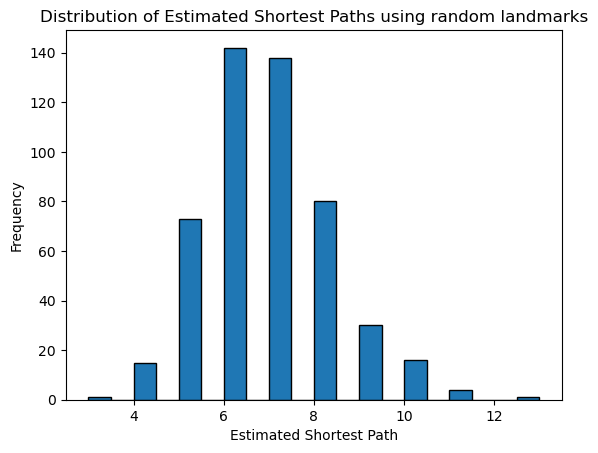

In [38]:
exact_shortest_paths = {}

for pair in random_node_pairs:
    source, target = pair
    shortest_path_distance = calculate_exact_shortest_path(G_dblp, source, target)
    exact_shortest_paths[pair] = shortest_path_distance

exact_shortest_paths


# Get the list of estimated shortest paths
estimations = list(exact_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Shortest Paths')
plt.show()

# Random Landmarks


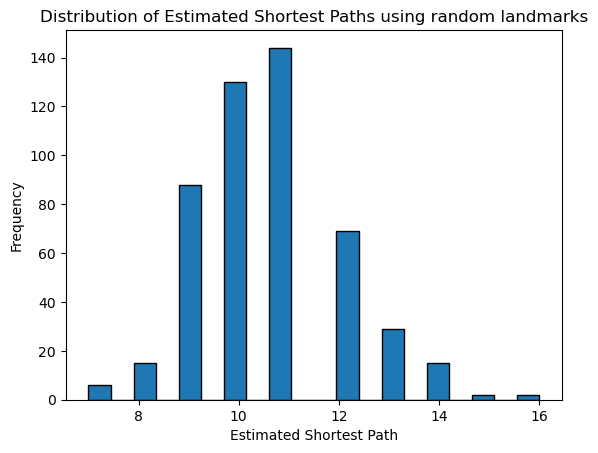

In [23]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
random_landmarks = generate_rng_landmark_list(G_dblp, 20)

# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, random_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
# print(estimated_shortest_paths)

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using random landmarks')
plt.show()

# Degree landmarks

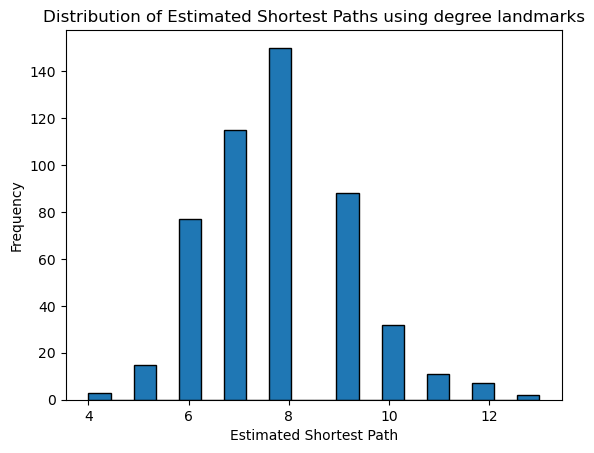

In [24]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
degree_landmarks = calculate_degree_centrality(G_dblp, 20, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
# print(estimated_shortest_paths)

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks')
plt.show()

# Closeness centrality landmarks

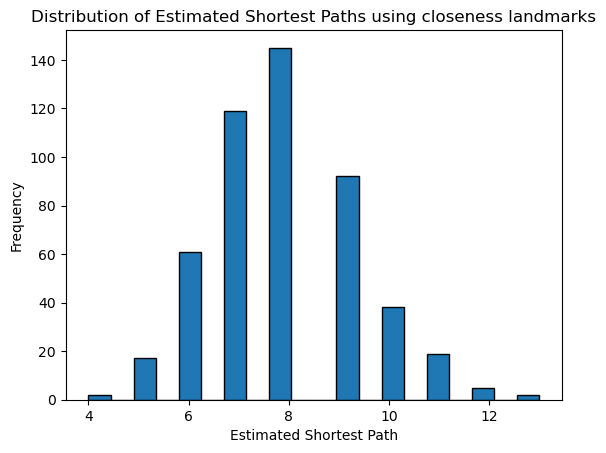

In [25]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_dblp, N=20, num_seeds=20, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
# print(estimated_shortest_paths)

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks')
plt.show()


# Betweenness landmarks


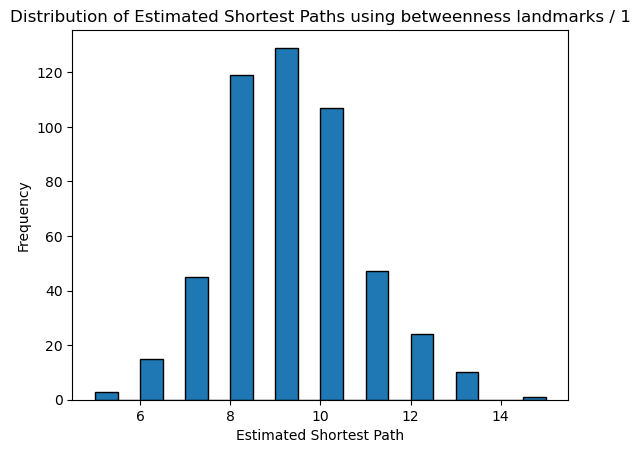

In [26]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_dblp, N=20, num_seeds=20, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
# print(estimated_shortest_paths)

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()

# Degree landmarks / 1

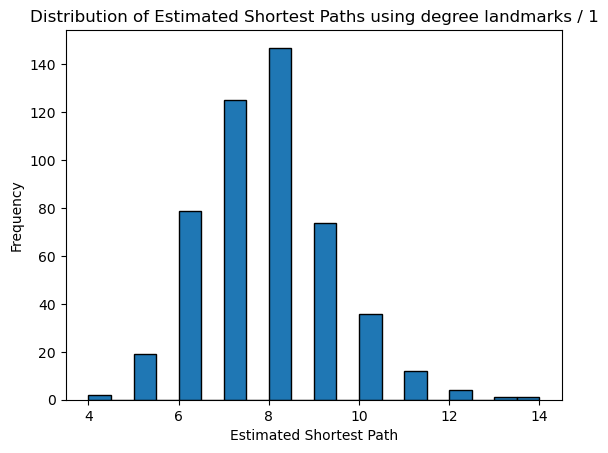

In [27]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
degree_landmarks = calculate_degree_centrality(G_dblp, 20, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
# print(estimated_shortest_paths)

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks / 1')
plt.show()


# Closeness landmarks / 1

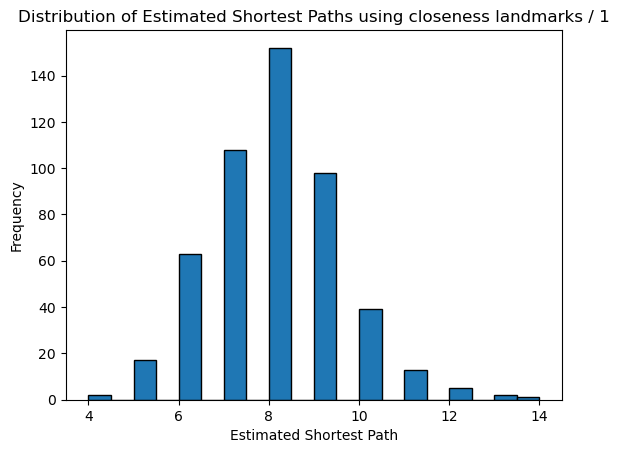

In [28]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_dblp, N=20, num_seeds=20, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
# print(estimated_shortest_paths)

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / 1')
plt.show()



# Betweenness landmarks / 1

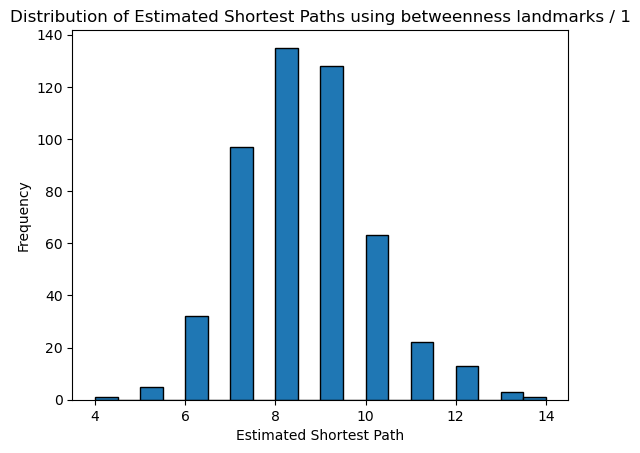

In [32]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_dblp, N=20, num_seeds=20, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Print the dictionary of estimated shortest paths
# print(estimated_shortest_paths)

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()

# Degree / P

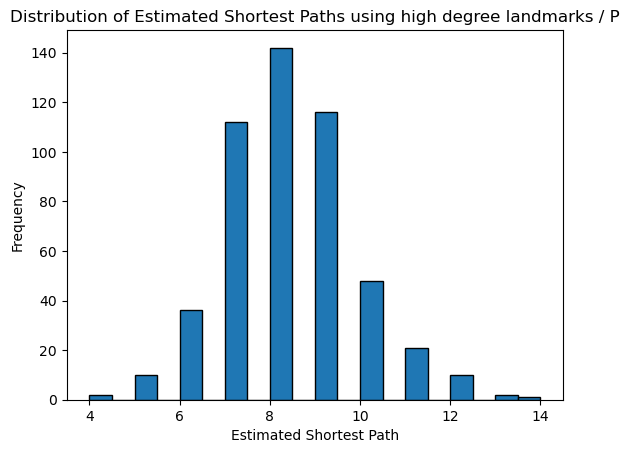

In [33]:
# Initialize dictionaries to store results
degree_centralities = {} 
estimated_shortest_paths = {}
estimations = {}

# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_dblp, partition)
    degree_centrality = calculate_degree_centrality(partition_graph, N=1, check_neighbors=False)

    degree_centralities.update(degree_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, degree_centralities)
    estimated_shortest_paths[(source, target)] = estimation


# Print the dictionary of estimated shortest paths
# print(estimated_shortest_paths)

# print("Number of partitions: " + str(number_partitions))
# print("\nNumber of landmarks: " + str(len(degree_centralities)))
# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using high degree landmarks / P')
plt.show()



# Closeness / P

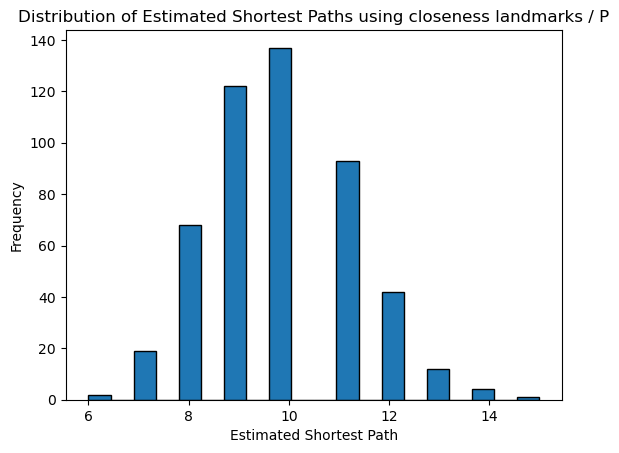

In [34]:
# Initialize dictionaries to store results
closeness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_dblp, partition)
    closeness_centrality = calculate_closeness_centrality(partition_graph, N=1, check_neighbors=False)

    closeness_centralities.update(closeness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, closeness_centralities)
    estimated_shortest_paths[(source, target)] = estimation


# Print the dictionary of estimated shortest paths
# print(estimated_shortest_paths)

# print("Number of partitions: " + str(number_partitions))
# print("\nNumber of landmarks: " + str(len(degree_centralities)))
# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / P')
plt.show()



# Betweenness / P

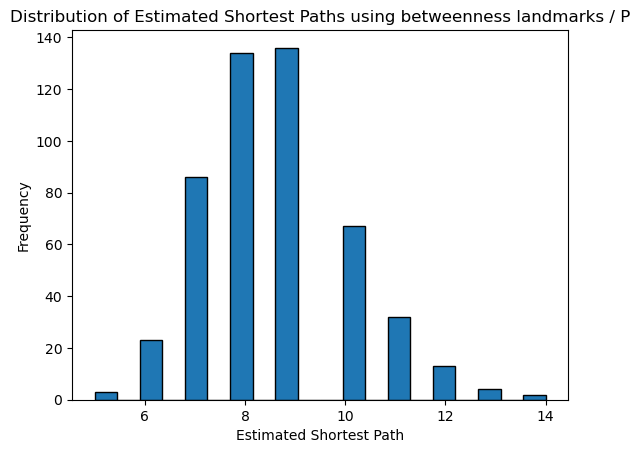

In [35]:
# Initialize dictionaries to store results
betweenness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_dblp, partition)
    betweenness_centrality = calculate_betweenness_centrality(partition_graph, N=1, check_neighbors=False)

    betweenness_centralities.update(betweenness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, betweenness_centralities)
    estimated_shortest_paths[(source, target)] = estimation


# Print the dictionary of estimated shortest paths
# print(estimated_shortest_paths)

# print("Number of partitions: " + str(number_partitions))
# print("\nNumber of landmarks: " + str(len(degree_centralities)))
# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / P')
plt.show()



# Border / P

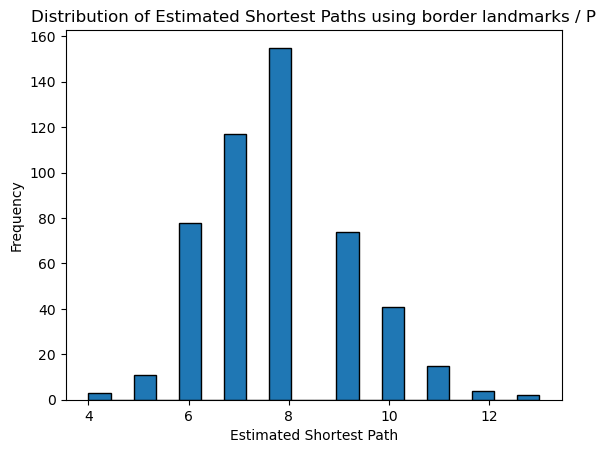

In [36]:
# Border landmarks in partitions
border_landmarks = get_highest_degree_nodes_border(G_dblp, number_partitions)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, border_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using border landmarks / P')
plt.show()

